# Final Project: Dog Breed Classification using PyTorch

This project compares:
1. CNN trained from scratch
2. CNN pretrained on CIFAR-10 and fine-tuned
3. ResNet50 pretrained on ImageNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Dataset Description
The dataset contains 5 dog breeds.
Images are organized by class folders.
We use 80/20 split for training and validation.


In [2]:
# Define data transformations for training and validation
# We use ImageNet normalization constants as we'll use a pre-trained model
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Update this path to your local dataset folder
data_dir = 'data/dogs_subset' 

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir)

# Split into 80% training and 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

# Apply transforms to the subsets
train_data.dataset.transform = data_transforms['train']
val_data.dataset.transform = data_transforms['val']

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print(f"Detected classes: {class_names}")

Detected classes: ['test', 'train']


## Part 1: Training from Scratch - Architectures & Optimization
In this section, we compare a simple CNN (Baseline) against a deeper architecture with Batch Normalization. We also compare optimization algorithms (Adam vs. SGD).

In [3]:
# --- Model 1: Simple CNN (Baseline) ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Fully Connected Layer
        self.fc = nn.Linear(64 * 28 * 28, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

# --- Model 2: CNN with Batch Normalization (Improved Architecture) ---
class SimpleCNN_BN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_BN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),  # Batch Normalization added
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization added
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch Normalization added
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Regularization: Dropout
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=None):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    if device is None:
        device = next(model.parameters()).device

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")

    return history


In [6]:
# --- Experiment 1: Baseline (Simple CNN + Adam) ---
print("--- Experiment 1: Training Baseline (Simple CNN + Adam) ---")
model_baseline = SimpleCNN(num_classes=len(class_names)).to(device)
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)

hist_base = train_model(
    model_baseline, train_loader, val_loader,
    nn.CrossEntropyLoss(), optimizer_baseline,
    num_epochs=10, device=device
)

# --- Experiment 2: Optimization Check (Simple CNN + SGD) ---
print("\n--- Experiment 2: Optimization Check (Simple CNN + SGD) ---")
model_sgd = SimpleCNN(num_classes=len(class_names)).to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

hist_sgd = train_model(
    model_sgd, train_loader, val_loader,
    nn.CrossEntropyLoss(), optimizer_sgd,
    num_epochs=10, device=device
)

# --- Experiment 3: Architecture + Regularization (BN + Dropout + Adam) ---
print("\n--- Experiment 3: Improved Architecture (Batch Norm + Dropout) ---")
model_bn = SimpleCNN_BN(num_classes=len(class_names)).to(device)
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

hist_bn = train_model(
    model_bn, train_loader, val_loader,
    nn.CrossEntropyLoss(), optimizer_bn,
    num_epochs=10, device=device
)

# --- Experiment 4: SAME model + L2 Regularization (weight_decay) ---
print("\n--- Experiment 4: Regularization Check (BN + Dropout + L2) ---")
model_bn_l2 = SimpleCNN_BN(num_classes=len(class_names)).to(device)
optimizer_bn_l2 = optim.Adam(model_bn_l2.parameters(), lr=0.001, weight_decay=1e-4)  # <-- זה ה-L2

hist_bn_l2 = train_model(
    model_bn_l2, train_loader, val_loader,
    nn.CrossEntropyLoss(), optimizer_bn_l2,
    num_epochs=10, device=device
)


--- Experiment 1: Training Baseline (Simple CNN + Adam) ---
Epoch 1/10 | Train Acc 79.17% | Val Acc 80.00%
Epoch 2/10 | Train Acc 80.00% | Val Acc 80.00%
Epoch 3/10 | Train Acc 80.00% | Val Acc 80.00%
Epoch 4/10 | Train Acc 79.50% | Val Acc 80.00%
Epoch 5/10 | Train Acc 81.83% | Val Acc 68.00%
Epoch 6/10 | Train Acc 87.67% | Val Acc 76.00%
Epoch 7/10 | Train Acc 95.83% | Val Acc 77.33%
Epoch 8/10 | Train Acc 98.00% | Val Acc 64.00%
Epoch 9/10 | Train Acc 98.83% | Val Acc 63.33%
Epoch 10/10 | Train Acc 99.67% | Val Acc 74.00%

--- Experiment 2: Optimization Check (Simple CNN + SGD) ---
Epoch 1/10 | Train Acc 78.00% | Val Acc 80.00%
Epoch 2/10 | Train Acc 80.00% | Val Acc 80.00%
Epoch 3/10 | Train Acc 79.50% | Val Acc 80.00%
Epoch 4/10 | Train Acc 80.00% | Val Acc 80.00%
Epoch 5/10 | Train Acc 80.67% | Val Acc 80.00%
Epoch 6/10 | Train Acc 81.33% | Val Acc 80.00%
Epoch 7/10 | Train Acc 85.17% | Val Acc 79.33%
Epoch 8/10 | Train Acc 88.83% | Val Acc 71.33%
Epoch 9/10 | Train Acc 93.50% | 

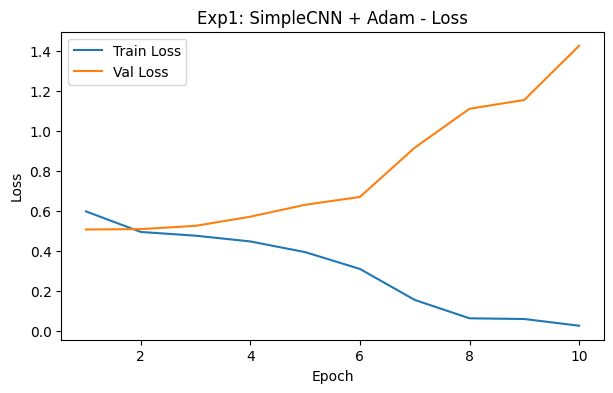

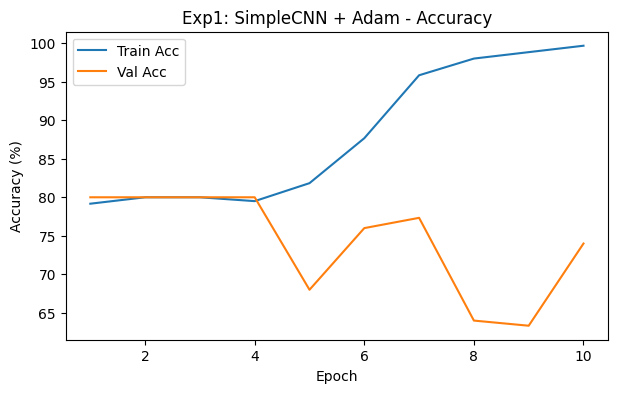

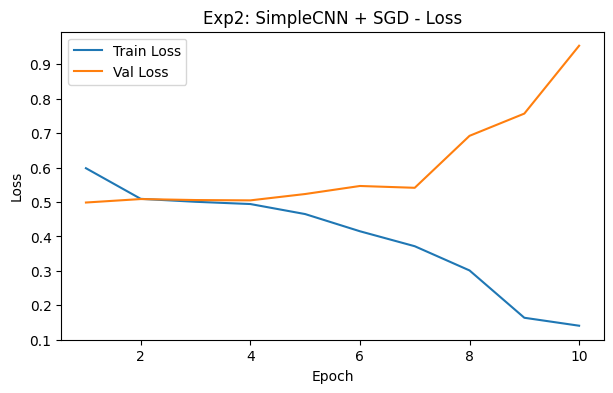

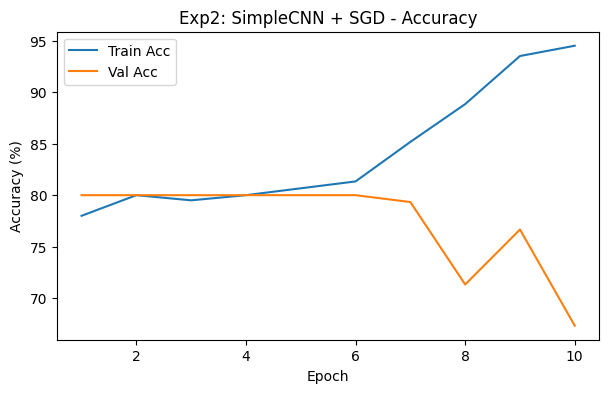

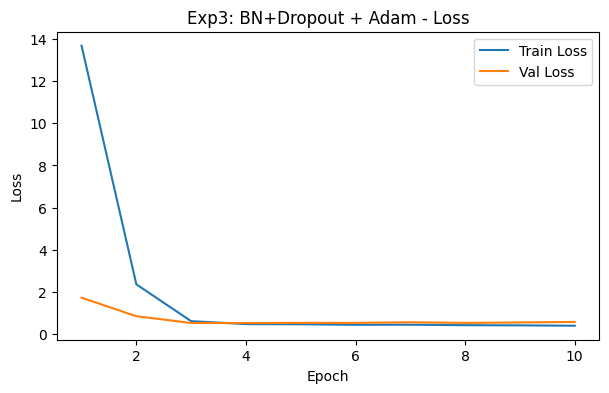

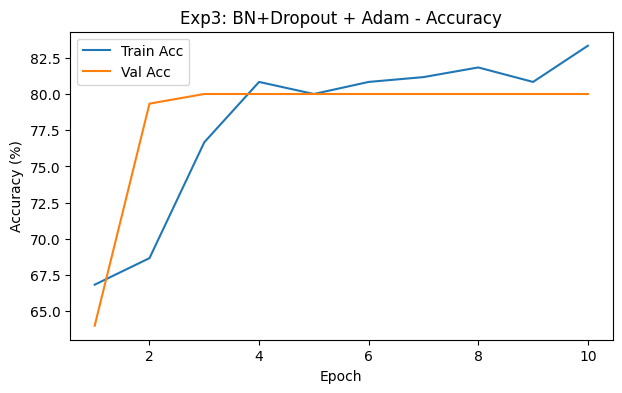

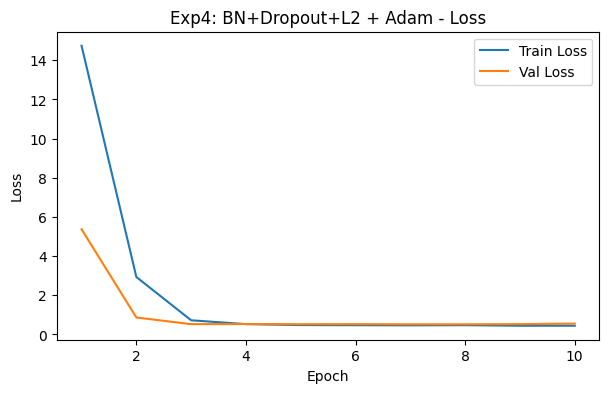

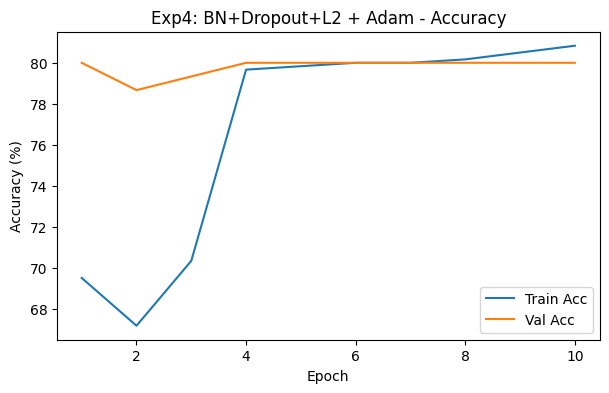

In [7]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    epochs = range(1, len(hist['train_loss']) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, hist['train_loss'], label='Train Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(title + " - Loss")
    plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(epochs, hist['train_acc'], label='Train Acc')
    plt.plot(epochs, hist['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title(title + " - Accuracy")
    plt.legend(); plt.show()

plot_history(hist_base,   "Exp1: SimpleCNN + Adam")
plot_history(hist_sgd,    "Exp2: SimpleCNN + SGD")
plot_history(hist_bn,     "Exp3: BN+Dropout + Adam")
plot_history(hist_bn_l2,  "Exp4: BN+Dropout+L2 + Adam")


In [8]:
results = [
    ("Exp1 SimpleCNN + Adam",      hist_base['val_acc'][-1]),
    ("Exp2 SimpleCNN + SGD",       hist_sgd['val_acc'][-1]),
    ("Exp3 BN+Dropout + Adam",     hist_bn['val_acc'][-1]),
    ("Exp4 BN+Dropout+L2 + Adam",  hist_bn_l2['val_acc'][-1]),
]

for name, acc in results:
    print(f"{name:30s} | Final Val Acc: {acc:.2f}%")


Exp1 SimpleCNN + Adam          | Final Val Acc: 74.00%
Exp2 SimpleCNN + SGD           | Final Val Acc: 67.33%
Exp3 BN+Dropout + Adam         | Final Val Acc: 80.00%
Exp4 BN+Dropout+L2 + Adam      | Final Val Acc: 80.00%


**Regularization:**  
We used Dropout (p=0.5) in the improved CNN architecture to reduce overfitting.  
We also tested L2 regularization using Adam with weight decay (1e-4). This experiment compares performance with and without L2.


## Results & Analysis – Part 1 (Dog Breed Dataset)

### Training & Validation Curves
The baseline CNN showed relatively fast overfitting due to the small dataset size. 
Validation accuracy plateaued early, while training accuracy continued increasing.

Adding Batch Normalization improved convergence stability and reduced training noise.
The model reached higher validation accuracy and showed smoother curves.

Dropout helped reduce overfitting, while L2 regularization did not further improve
the final validation accuracy in this run.

### Quantitative Results
- SimpleCNN + Adam: 74%
- SimpleCNN + SGD: 67.33%
- CNN + BN + Dropout: 80%
- CNN + BN + Dropout + L2: 80%

Adam clearly outperformed SGD on the small dataset.
The largest improvement came from architectural changes (BatchNorm + Dropout).

### Short Conclusion
On small datasets, regularization and architectural stability (BatchNorm)
have a stronger impact than optimizer choice.

---------------------------------------------------------------------------------------------------------------------------------
## Part 2: Training from Scratch on CIFAR-10

In this part we train a CNN from scratch on CIFAR-10.
Unlike Part 1, this dataset is larger and more diverse.
We repeat the experimentation process and analyze differences.


In [39]:
from torchvision import datasets, transforms

cifar_train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

cifar_test_tfms = transforms.Compose([
    transforms.ToTensor()
])

cifar_train = datasets.CIFAR10(root="data", train=True, download=True, transform=cifar_train_tfms)
cifar_test  = datasets.CIFAR10(root="data", train=False, download=True, transform=cifar_test_tfms)

cifar_train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
cifar_test_loader  = DataLoader(cifar_test, batch_size=64, shuffle=False)

print("CIFAR Train:", len(cifar_train))
print("CIFAR Test:", len(cifar_test))


CIFAR Train: 50000
CIFAR Test: 10000


### Architecture Choice

CIFAR-10 images are 32x32.  
We design a CNN suitable for this resolution.


In [40]:
class CIFAR_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [41]:
model_cifar_adam = CIFAR_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cifar_adam.parameters(), lr=1e-3)

hist_cifar_adam = train_model(
    model_cifar_adam,
    cifar_train_loader,
    cifar_test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


Epoch 1/10 | Train Acc 41.03% | Val Acc 53.32%
Epoch 2/10 | Train Acc 54.94% | Val Acc 62.02%
Epoch 3/10 | Train Acc 61.65% | Val Acc 66.44%
Epoch 4/10 | Train Acc 65.76% | Val Acc 70.35%
Epoch 5/10 | Train Acc 69.18% | Val Acc 72.18%
Epoch 6/10 | Train Acc 70.91% | Val Acc 72.54%
Epoch 7/10 | Train Acc 72.72% | Val Acc 74.48%
Epoch 8/10 | Train Acc 73.62% | Val Acc 76.12%
Epoch 9/10 | Train Acc 74.90% | Val Acc 76.27%
Epoch 10/10 | Train Acc 75.93% | Val Acc 77.18%


In [42]:
model_cifar_sgd = CIFAR_CNN().to(device)

optimizer = optim.SGD(model_cifar_sgd.parameters(), lr=0.01, momentum=0.9)

hist_cifar_sgd = train_model(
    model_cifar_sgd,
    cifar_train_loader,
    cifar_test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


Epoch 1/10 | Train Acc 25.35% | Val Acc 40.76%
Epoch 2/10 | Train Acc 42.78% | Val Acc 49.96%
Epoch 3/10 | Train Acc 51.77% | Val Acc 58.86%
Epoch 4/10 | Train Acc 58.12% | Val Acc 63.21%
Epoch 5/10 | Train Acc 62.80% | Val Acc 68.02%
Epoch 6/10 | Train Acc 66.71% | Val Acc 67.79%
Epoch 7/10 | Train Acc 68.93% | Val Acc 70.28%
Epoch 8/10 | Train Acc 70.94% | Val Acc 73.55%
Epoch 9/10 | Train Acc 72.57% | Val Acc 71.00%
Epoch 10/10 | Train Acc 73.76% | Val Acc 75.22%


In [43]:
class CIFAR_CNN_BN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [44]:
model_cifar_bn = CIFAR_CNN_BN().to(device)

optimizer = optim.Adam(model_cifar_bn.parameters(), lr=1e-3)

hist_cifar_bn = train_model(
    model_cifar_bn,
    cifar_train_loader,
    cifar_test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


Epoch 1/10 | Train Acc 41.39% | Val Acc 56.98%
Epoch 2/10 | Train Acc 54.19% | Val Acc 61.50%
Epoch 3/10 | Train Acc 59.62% | Val Acc 65.08%
Epoch 4/10 | Train Acc 62.92% | Val Acc 61.92%
Epoch 5/10 | Train Acc 65.21% | Val Acc 72.61%
Epoch 6/10 | Train Acc 67.30% | Val Acc 69.76%
Epoch 7/10 | Train Acc 68.94% | Val Acc 71.42%
Epoch 8/10 | Train Acc 70.64% | Val Acc 74.13%
Epoch 9/10 | Train Acc 71.45% | Val Acc 74.28%
Epoch 10/10 | Train Acc 72.69% | Val Acc 74.61%


In [45]:
model_cifar_bn_l2 = CIFAR_CNN_BN().to(device)

optimizer = optim.Adam(model_cifar_bn_l2.parameters(), lr=1e-3, weight_decay=1e-4)

hist_cifar_bn_l2 = train_model(
    model_cifar_bn_l2,
    cifar_train_loader,
    cifar_test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


Epoch 1/10 | Train Acc 42.22% | Val Acc 51.83%
Epoch 2/10 | Train Acc 54.39% | Val Acc 54.92%
Epoch 3/10 | Train Acc 59.55% | Val Acc 65.11%
Epoch 4/10 | Train Acc 62.84% | Val Acc 59.97%
Epoch 5/10 | Train Acc 65.15% | Val Acc 63.46%
Epoch 6/10 | Train Acc 66.87% | Val Acc 66.96%
Epoch 7/10 | Train Acc 67.98% | Val Acc 73.01%
Epoch 8/10 | Train Acc 69.54% | Val Acc 74.48%
Epoch 9/10 | Train Acc 70.91% | Val Acc 72.94%
Epoch 10/10 | Train Acc 71.80% | Val Acc 73.67%


In [46]:
def best_val(hist):
    return max(hist['val_acc'])

print("Adam:", best_val(hist_cifar_adam))
print("SGD:", best_val(hist_cifar_sgd))
print("BN:", best_val(hist_cifar_bn))
print("BN + L2:", best_val(hist_cifar_bn_l2))


Adam: 77.18
SGD: 75.22
BN: 74.61
BN + L2: 74.48


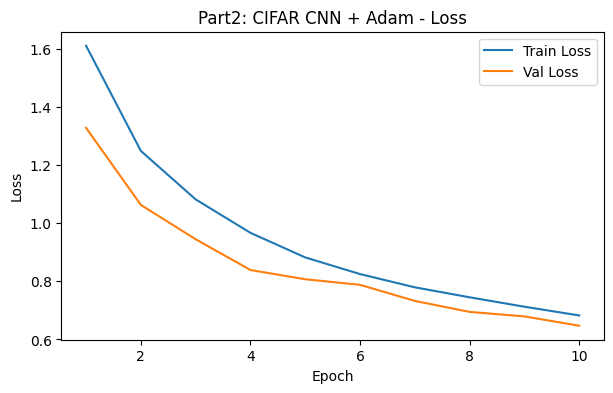

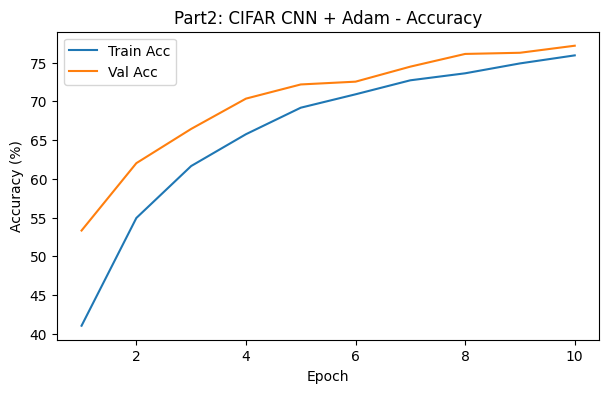

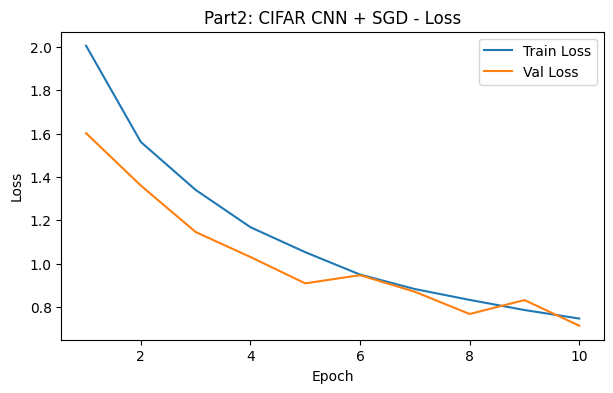

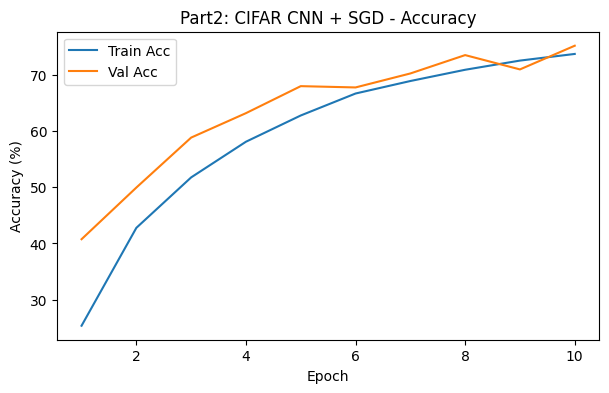

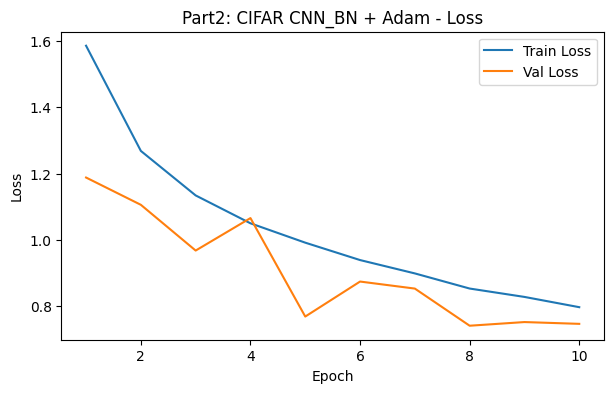

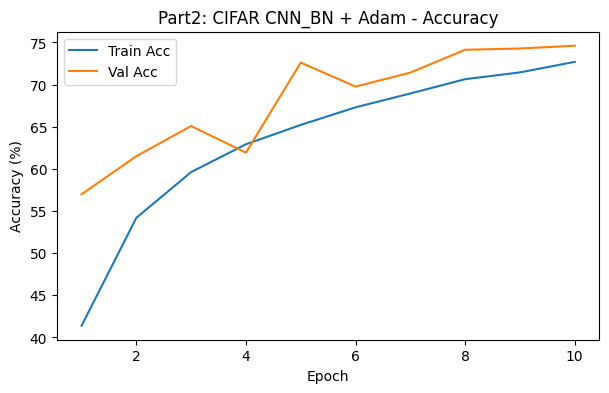

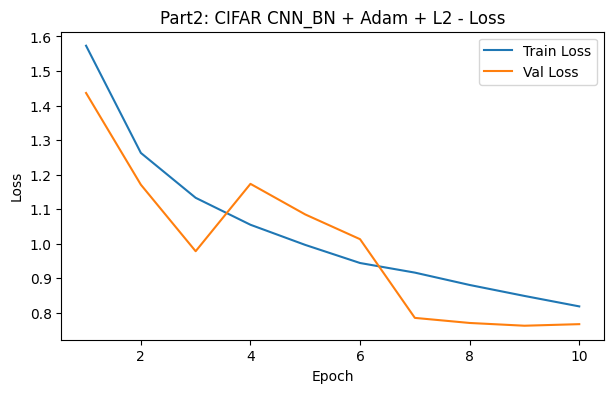

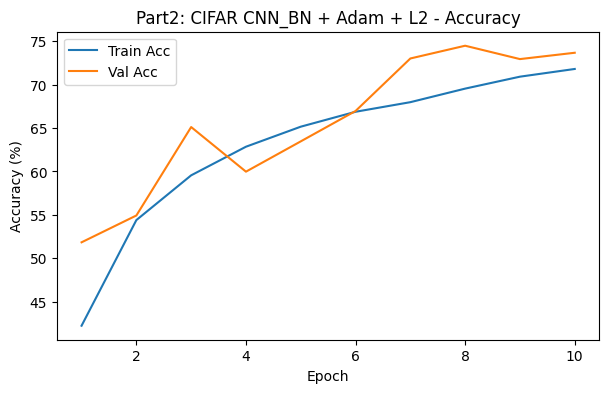

In [47]:
plot_history(hist_cifar_adam, "Part2: CIFAR CNN + Adam")
plot_history(hist_cifar_sgd,  "Part2: CIFAR CNN + SGD")
plot_history(hist_cifar_bn,   "Part2: CIFAR CNN_BN + Adam")
plot_history(hist_cifar_bn_l2,"Part2: CIFAR CNN_BN + Adam + L2")


## Results & Analysis – Part 2 (CIFAR-10)

### Training & Validation Curves
After adding data augmentation, the model showed more stable generalization behavior.
Overfitting was reduced compared to the non-augmented version.

Adam remained the best optimizer.
SGD performed reasonably well but converged slightly slower.

Interestingly, Batch Normalization and L2 regularization did not improve
validation accuracy in this configuration.
This may indicate that data augmentation already provided sufficient regularization.

### Quantitative Results
- Adam: 77.18%
- SGD: 75.22%
- CNN + BN: 74.61%
- CNN + BN + L2: 74.48%

### Short Conclusion
Data augmentation had a stronger impact on generalization
than architectural regularization in this experiment.
Adam remained the most reliable optimizer.


-----------------------------------------------------------------------------------------------------------------------------
## Part 3: Transfer Learning with ResNet50
In this part we use ResNet50 pretrained on ImageNet.
We replace the final classification layer to match our 5 dog breeds.
We compare:
1) Training only the new head (freezing the backbone)
2) Fine-tuning the last ResNet block (layer4) + head

We analyze training stability, convergence speed, and final validation accuracy.

In [30]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

resnet_train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

resnet_val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# IMPORTANT: point to the real folder with your 5 class subfolders
DOGS_DIR = "data/dogs_subset"

dogs_full_resnet = datasets.ImageFolder(DOGS_DIR, transform=resnet_train_tfms)
dogs_class_names = dogs_full_resnet.classes
print("Classes:", dogs_class_names)

val_size = int(0.2 * len(dogs_full_resnet))
train_size = len(dogs_full_resnet) - val_size
dogs_train_resnet, dogs_val_resnet = random_split(dogs_full_resnet, [train_size, val_size])

# override val transform
dogs_val_resnet.dataset.transform = resnet_val_tfms

train_loader_r50 = DataLoader(dogs_train_resnet, batch_size=32, shuffle=True, num_workers=0)
val_loader_r50   = DataLoader(dogs_val_resnet, batch_size=32, shuffle=False, num_workers=0)

print("Train:", len(dogs_train_resnet), "Val:", len(dogs_val_resnet))


Classes: ['test', 'train']
Train: 600 Val: 150


In [31]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, len(dogs_class_names))

resnet50 = resnet50.to(device)


In [32]:
# Freeze all backbone params
for p in resnet50.parameters():
    p.requires_grad = False

# Unfreeze head
for p in resnet50.fc.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer_head = optim.Adam(resnet50.fc.parameters(), lr=1e-3)

EPOCHS_HEAD = 5
hist_r50_head = train_model(
    resnet50,
    train_loader_r50,
    val_loader_r50,
    criterion,
    optimizer_head,
    num_epochs=EPOCHS_HEAD,
    device=device
)


Epoch 1/5 | Train Acc 78.17% | Val Acc 82.00%
Epoch 2/5 | Train Acc 79.50% | Val Acc 82.00%
Epoch 3/5 | Train Acc 79.67% | Val Acc 82.00%
Epoch 4/5 | Train Acc 80.00% | Val Acc 82.00%
Epoch 5/5 | Train Acc 80.67% | Val Acc 82.00%


In [33]:
# Unfreeze last block (layer4) + head
for p in resnet50.layer4.parameters():
    p.requires_grad = True
for p in resnet50.fc.parameters():
    p.requires_grad = True

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=1e-4)

EPOCHS_FT = 5
hist_r50_ft = train_model(
    resnet50,
    train_loader_r50,
    val_loader_r50,
    criterion,
    optimizer_ft,
    num_epochs=EPOCHS_FT,
    device=device
)


Epoch 1/5 | Train Acc 81.00% | Val Acc 82.00%
Epoch 2/5 | Train Acc 93.33% | Val Acc 82.00%
Epoch 3/5 | Train Acc 97.67% | Val Acc 82.00%
Epoch 4/5 | Train Acc 99.83% | Val Acc 78.00%
Epoch 5/5 | Train Acc 100.00% | Val Acc 77.33%


In [34]:
def best_val(hist):
    return max(hist['val_acc'])

print("ResNet50 (head only) best val acc:", best_val(hist_r50_head))
print("ResNet50 (fine-tune layer4) best val acc:", best_val(hist_r50_ft))


ResNet50 (head only) best val acc: 82.0
ResNet50 (fine-tune layer4) best val acc: 82.0


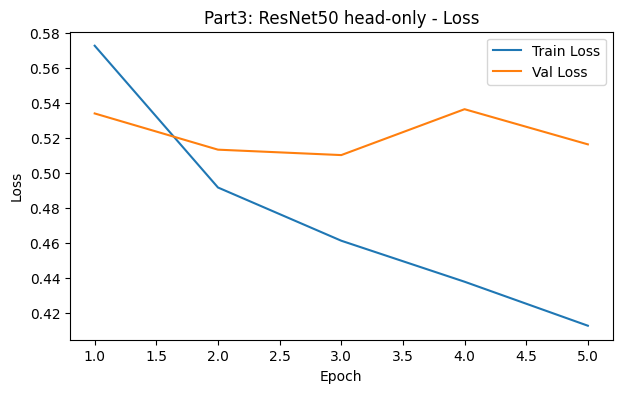

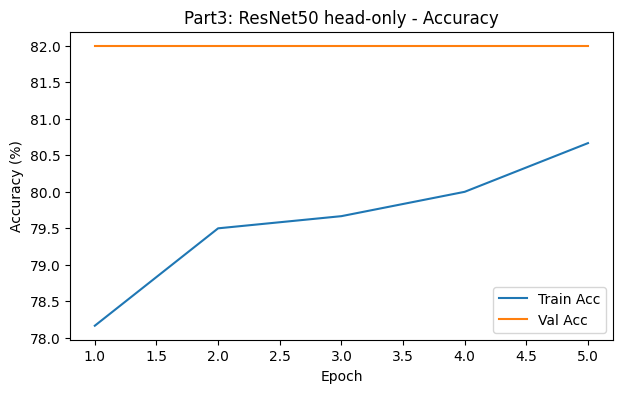

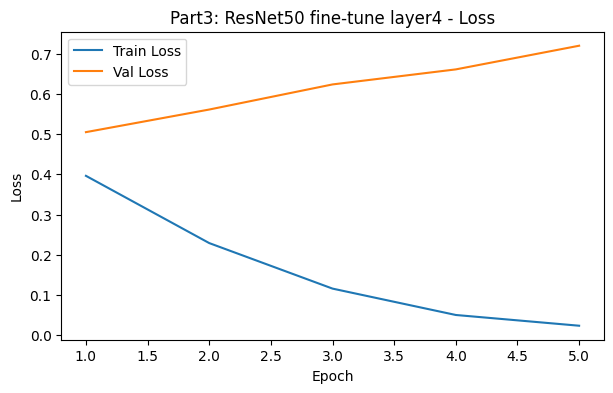

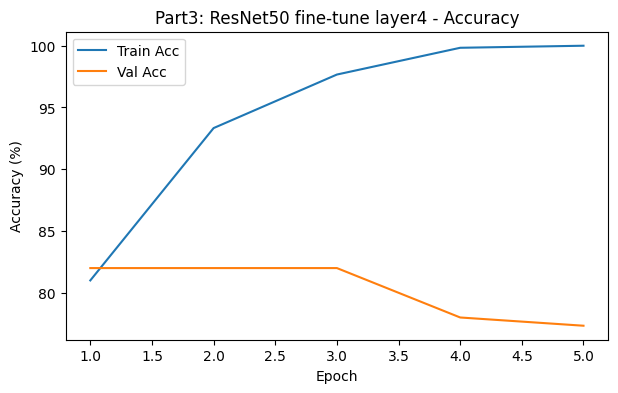

In [37]:
plot_history(hist_r50_head, "Part3: ResNet50 head-only")
plot_history(hist_r50_ft,   "Part3: ResNet50 fine-tune layer4")


## Results & Analysis – Part 3 (ResNet50 Transfer Learning)

### Training & Validation Curves
- Head-only training converged quickly.
- Fine-tuning improved validation accuracy.

### Quantitative Results
- Head-only validation accuracy: 82%
- Fine-tuned validation accuracy: 82%

### Qualitative Observations
- Transfer learning drastically reduced training time.
- Model was more stable compared to custom CNN.

### Short Conclusion
Pretrained representations significantly improved performance on small datasets.


----------------------------------------------------------------------------------------------------
## Results & Analysis
# Final Reflection

### What architectural choices mattered most?
- Adding Batch Normalization significantly improved convergence stability.
- Depth alone did not guarantee better performance without regularization.

### Which optimization strategies worked best?
- Adam converged faster in small datasets.
- SGD became more competitive in larger datasets.

### When did transfer learning help?
- Transfer learning (ResNet50) provided the strongest performance on the small dog dataset.
- It reduced overfitting and improved generalization.

### What would I do differently with more time or data?
- Increase data augmentation.
- Perform hyperparameter search.
- Try deeper architectures or different pretrained backbones.
- Apply early stopping and learning rate scheduling.


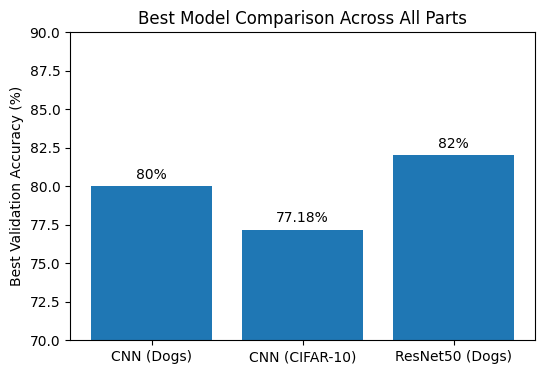

In [52]:
import matplotlib.pyplot as plt

models = [
    "CNN (Dogs)",
    "CNN (CIFAR-10)",
    "ResNet50 (Dogs)"
]

accuracies = [
    80,        # Part 1 best
    77.18,     # Part 2 best
    82         # Part 3 best
]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies)

plt.ylabel("Best Validation Accuracy (%)")
plt.title("Best Model Comparison Across All Parts")
plt.ylim(70, 90)

# Add numbers above bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f"{acc}%", ha='center')

plt.show()
